1. выделить номер
2. повернуть номер
3. выделить буквы 
4. найти готовые шаблоны(из гостовских)
5. начать распознавать буквы(завтра)
6. прикрутить к видеокамере(в будущем)
7. после этого надо будет усовершенствовать алгоритм(скорость и качество)

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
def find_goal_img(contours, img, start_img):
    goal_coord = []
    goal_img = ""
    for cnt in contours: 
        x,y,w,h = cv.boundingRect(cnt)
        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.int64(box)
        if h < 32 and h > 15 and w > 103 and w < 120:
            if w/h > 3 and w/h < 4.8:
                cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                cv.drawContours(img,[box],0,(255, 0 ,0),2)
                goal_coord = [x, y, w, h]
                goal_rect = rect
                goal_img = start_img[y-1:y+h, x:x+w]
                print('w, h: ', w, h)
                print('w/h: ', w/h)
                print(rect, "rect")
                break
    
    if goal_coord == []:
        return None
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.imshow(goal_img, cmap='gray')
    plt.show()
    return find_angle(goal_img, goal_rect)

In [3]:
def find_angle(goal_img, goal_rect):
    height, width = goal_img.shape[:2]
    print(goal_rect)

    center = (width//2, height//2) 
    angle2 = goal_rect[2]
    print(angle2)
    if angle2 == 90:
        rotated_image = goal_img
    elif angle2 > 45 and angle2 < 90:
        rotate_matrix = cv.getRotationMatrix2D(center=center, angle=goal_rect[2]-90, scale=1) 
        rotated_image = cv.warpAffine(src=goal_img, M=rotate_matrix, dsize=(width,height)) 
    else:
        rotate_matrix = cv.getRotationMatrix2D(center=center, angle=goal_rect[2], scale=1) 
        rotated_image = cv.warpAffine(src=goal_img, M=rotate_matrix, dsize=(width,height)) 
    plt.imshow(rotated_image, cmap='gray')
    plt.show()
    return find_symbols(rotated_image)

In [4]:
def find_symbols(rotated_image):
    symbols = []
    y0_start = 1
    y1_start = -3
    x0_start = 5
    x1_start = 24
    gap = 13
    gap_numbers = 1
    for i in range(6):
        first_symbol = rotated_image[y0_start:y1_start, x0_start+gap_numbers+gap*i:x1_start+gap_numbers+gap*i]
        symbols.append(first_symbol)
        
    y0_start = 0
    y1_start = -10
    x0_start = 3
    x1_start = 17
    gap = 10
    for i in range(1, -1, -1):
        first_symbol = rotated_image[y0_start:y1_start, -1*(x1_start+gap_numbers+gap*i):-1*(x0_start+gap_numbers+gap*i)]
        symbols.append(first_symbol)

    print('size symbols: ', len(symbols))
    return find_match(symbols, rotated_image)      

In [5]:
def read_img(path_to_file, options='', show=False):
    if options != '':
        img = cv.imread(path_to_file, options)
    else:
        img = cv.imread(path_to_file)
    assert img is not None, "file could not be read, check with os.path.exists()"
    if show:
        cv.imshow("Display window", img)
    return img

In [6]:
def find_match(symbols, rotated_image):
    alphabet = {'A': 0, 'B': 0, 'C': 0, 'E': 0, 'H': 0, 'K': 0, 'M': 0, 'O': 0, 'P': 0, 'T': 0, 'X': 0, 'Y': 0}
    all = []
   
    for j, img in enumerate(symbols):
        a = {}
        tmp_max_val = 0
        tmp_max_sym = ''
        tmp_top_left = 0
        tmp_template = ''
        max_tmp_img = None
        if j == 0 or j == 4 or j == 5:
            for i in alphabet:
                max_loc, max_val, template, tmp_img = matching(img, f'./Alphabhet/{i}.png', (13, 16))

                a[i] = max_val
                top_left = max_loc
                
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_top_left = top_left
                    tmp_template = template
                    max_tmp_img = tmp_img

        if j == 1 or j == 2 or j == 3:
            for i in range(10):
                max_loc, max_val, template, tmp_img = matching(img, f'./Nums/{i}.png', (13, 20))

                a[i] = max_val
                top_left = max_loc
                
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_top_left = top_left
                    tmp_template = template
                    max_tmp_img = tmp_img

        if j > 5:
            for i in range(10):
                max_loc, max_val, template, tmp_img = matching(img, f'./Nums/{i}.png', (11, 14))

                a[i] = max_val
                top_left = max_loc
                
                if tmp_max_val == 0 or tmp_max_val < max_val:
                    tmp_max_val = max_val
                    tmp_max_sym = i
                    tmp_top_left = top_left
                    tmp_template = template
                    max_tmp_img = tmp_img

        
            
        w, h = tmp_template.shape[::-1]
        bottom_right = (tmp_top_left[0] + w, tmp_top_left[1] + h)
        new_img = img.copy()
        cv.rectangle(new_img,tmp_top_left, bottom_right, 255, 1)

        plt.subplot(131),plt.imshow(tmp_template,cmap = 'gray')
        plt.title('Template'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(new_img,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(max_tmp_img,cmap = 'gray')
        plt.title('Tmp_img'), plt.xticks([]), plt.yticks([])

        plt.show()
        all.append(a)
        print(a)

    print(all)
    final_mas = []
    final_string = ''
    for obj in all:
        max_pred = max(obj.items(), key=lambda x: x[1])
        final_mas.append(max_pred)
        final_string += str(max_pred[0])
    print(final_string)
    return(final_string)

In [7]:
def matching(img, path_template, size):
    template = read_img(path_template, cv.IMREAD_GRAYSCALE)
    template = cv.resize(template, size)
    tmp_img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY, 15, 2)
    method = eval('cv.TM_CCOEFF_NORMED')
    res = cv.matchTemplate(tmp_img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    return (max_loc, max_val, template, tmp_img)

thr:  60
thr:  70
thr:  80
thr:  90
thr:  100
thr:  110
thr:  120
thr:  130
w, h:  118 28
w/h:  4.214285714285714
((644.5, 223.5), (27.0, 117.0), 90.0) rect


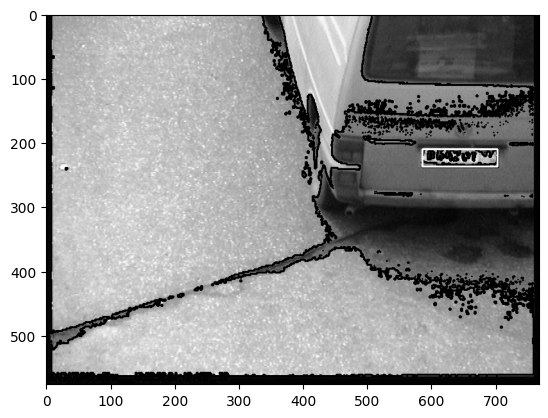

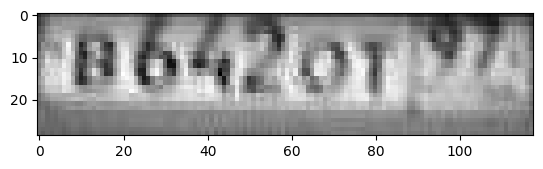

((644.5, 223.5), (27.0, 117.0), 90.0)
90.0


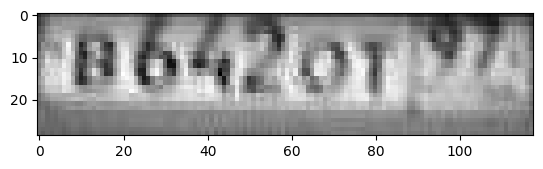

size symbols:  8


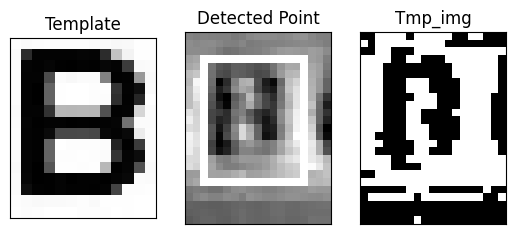

{'A': 0.36554720997810364, 'B': 0.5683354735374451, 'C': 0.35205078125, 'E': 0.45615196228027344, 'H': 0.3118879497051239, 'K': 0.40654638409614563, 'M': 0.1640573889017105, 'O': 0.34924936294555664, 'P': 0.5032373666763306, 'T': 0.4195804297924042, 'X': 0.19674502313137054, 'Y': 0.28171229362487793}


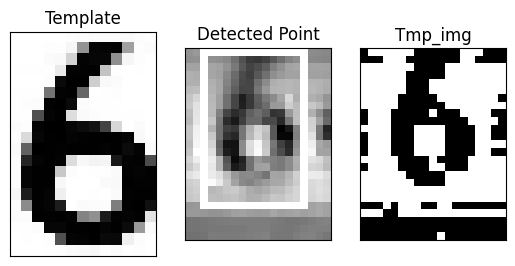

{0: 0.2657385468482971, 1: 0.23386409878730774, 2: 0.3927227556705475, 3: 0.1668262481689453, 4: 0.38737165927886963, 5: 0.28436478972435, 6: 0.49317604303359985, 7: 0.12679673731327057, 8: 0.355499267578125, 9: 0.29886218905448914}


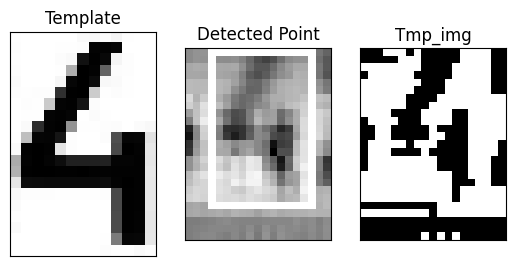

{0: 0.19285404682159424, 1: 0.4116760492324829, 2: 0.3023788630962372, 3: 0.2333509624004364, 4: 0.6051260232925415, 5: 0.2923251688480377, 6: 0.40186524391174316, 7: 0.14174793660640717, 8: 0.2812690734863281, 9: 0.3296286165714264}


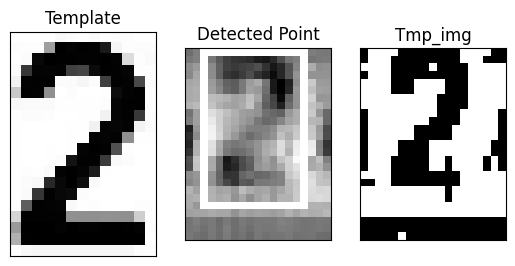

{0: 0.24692539870738983, 1: 0.245652973651886, 2: 0.5985686779022217, 3: 0.37567535042762756, 4: 0.32772183418273926, 5: 0.24107269942760468, 6: 0.20517276227474213, 7: 0.5010786652565002, 8: 0.2832513749599457, 9: 0.2819916009902954}


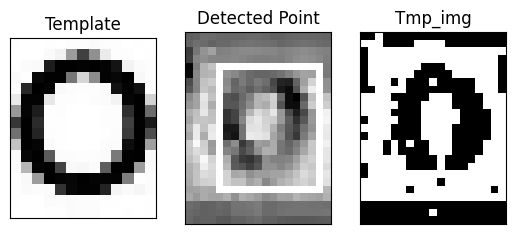

{'A': 0.3164900541305542, 'B': 0.5220597982406616, 'C': 0.47590240836143494, 'E': 0.31283533573150635, 'H': 0.3175354599952698, 'K': 0.22500477731227875, 'M': 0.08176199346780777, 'O': 0.6371720433235168, 'P': 0.3724839389324188, 'T': 0.4530348777770996, 'X': 0.2543444335460663, 'Y': 0.25644436478614807}


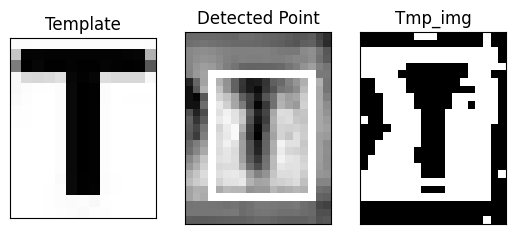

{'A': 0.2074725478887558, 'B': 0.24202722311019897, 'C': 0.18864256143569946, 'E': 0.39923202991485596, 'H': 0.27390727400779724, 'K': 0.16754135489463806, 'M': 0.19487424194812775, 'O': 0.2538314461708069, 'P': 0.2811167240142822, 'T': 0.70252925157547, 'X': 0.2860885560512543, 'Y': 0.5494974851608276}


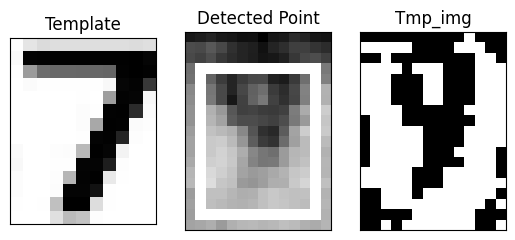

{0: 0.09126878529787064, 1: 0.3629596531391144, 2: 0.2934899628162384, 3: 0.24235141277313232, 4: 0.18971754610538483, 5: 0.23593716323375702, 6: 0.12602980434894562, 7: 0.5294910073280334, 8: 0.25230321288108826, 9: 0.47651827335357666}


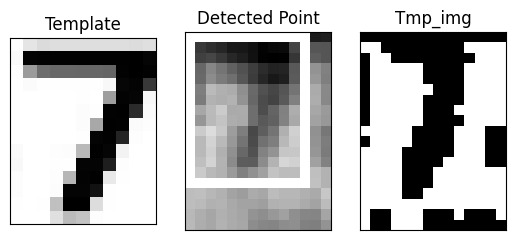

{0: 0.16068525612354279, 1: 0.2598395347595215, 2: 0.30092817544937134, 3: 0.24857200682163239, 4: 0.3400561809539795, 5: 0.10340771079063416, 6: 0.3936249613761902, 7: 0.5563653111457825, 8: 0.10390765964984894, 9: 0.33502912521362305}
[{'A': 0.36554720997810364, 'B': 0.5683354735374451, 'C': 0.35205078125, 'E': 0.45615196228027344, 'H': 0.3118879497051239, 'K': 0.40654638409614563, 'M': 0.1640573889017105, 'O': 0.34924936294555664, 'P': 0.5032373666763306, 'T': 0.4195804297924042, 'X': 0.19674502313137054, 'Y': 0.28171229362487793}, {0: 0.2657385468482971, 1: 0.23386409878730774, 2: 0.3927227556705475, 3: 0.1668262481689453, 4: 0.38737165927886963, 5: 0.28436478972435, 6: 0.49317604303359985, 7: 0.12679673731327057, 8: 0.355499267578125, 9: 0.29886218905448914}, {0: 0.19285404682159424, 1: 0.4116760492324829, 2: 0.3023788630962372, 3: 0.2333509624004364, 4: 0.6051260232925415, 5: 0.2923251688480377, 6: 0.40186524391174316, 7: 0.14174793660640717, 8: 0.2812690734863281, 9: 0.329628616

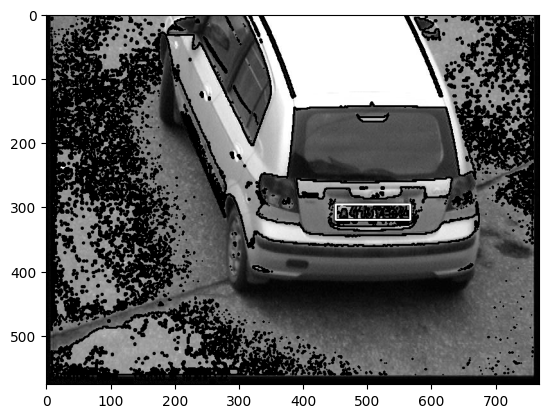

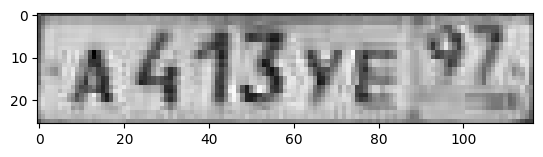

((509.0, 308.0), (24.0, 116.0), 90.0)
90.0


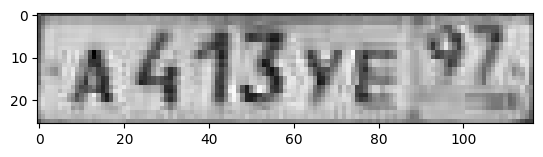

size symbols:  8


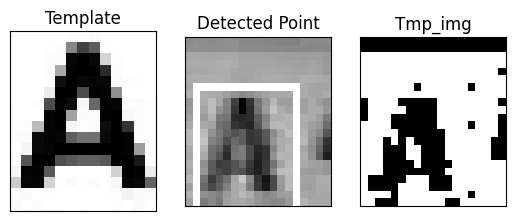

{'A': 0.6186972260475159, 'B': 0.1579868495464325, 'C': 0.24438126385211945, 'E': 0.34578874707221985, 'H': 0.22029897570610046, 'K': 0.3625237047672272, 'M': 0.15425515174865723, 'O': 0.2185983508825302, 'P': 0.228746697306633, 'T': 0.2401564121246338, 'X': 0.3757408857345581, 'Y': 0.2805054187774658}


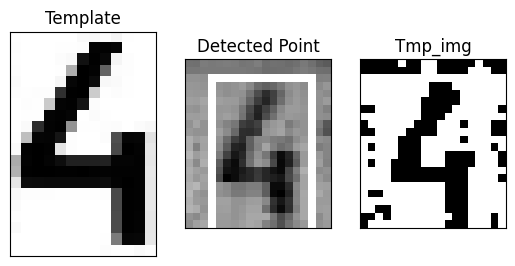

{0: 0.10925289243459702, 1: 0.3702699840068817, 2: 0.09296083450317383, 3: 0.2104281783103943, 4: 0.6856294274330139, 5: 0.05681975930929184, 6: 0.3279757797718048, 7: 0.17128689587116241, 8: 0.1319342702627182, 9: 0.12736797332763672}


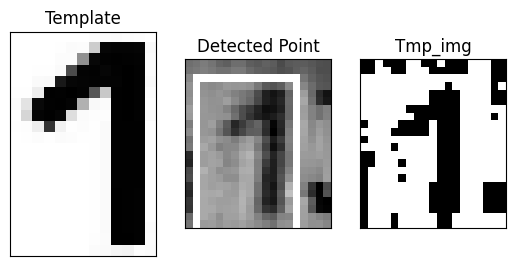

{0: 0.13539986312389374, 1: 0.7006624937057495, 2: 0.0897265076637268, 3: 0.25552934408187866, 4: 0.28970298171043396, 5: 0.07542734593153, 6: 0.15193817019462585, 7: 0.20461143553256989, 8: 0.1509658843278885, 9: 0.20263390243053436}


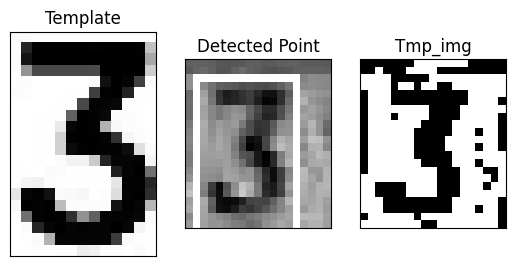

{0: 0.304082989692688, 1: 0.320571631193161, 2: 0.423019140958786, 3: 0.6477625370025635, 4: 0.1729724407196045, 5: 0.34699323773384094, 6: 0.20550841093063354, 7: 0.32262325286865234, 8: 0.41037842631340027, 9: 0.24566130340099335}


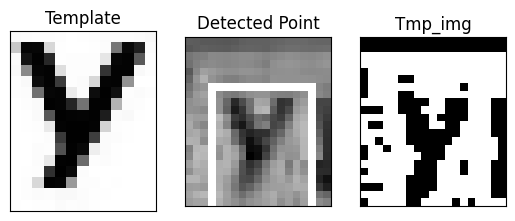

{'A': 0.23513121902942657, 'B': 0.1917722523212433, 'C': 0.18887241184711456, 'E': 0.4120499789714813, 'H': 0.1905227154493332, 'K': 0.3617035150527954, 'M': 0.15807248651981354, 'O': 0.10938820242881775, 'P': 0.2744469940662384, 'T': 0.3799503445625305, 'X': 0.42430323362350464, 'Y': 0.6675069332122803}


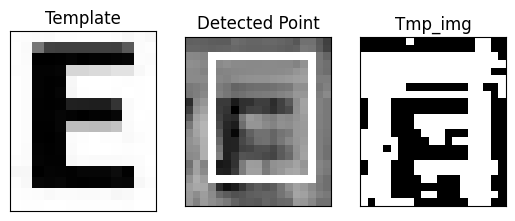

{'A': 0.3644969165325165, 'B': 0.364888995885849, 'C': 0.3517827093601227, 'E': 0.46383848786354065, 'H': 0.1990402340888977, 'K': 0.2753223776817322, 'M': 0.26322656869888306, 'O': 0.20108135044574738, 'P': 0.25628793239593506, 'T': 0.2385723888874054, 'X': 0.1966090351343155, 'Y': 0.26501938700675964}


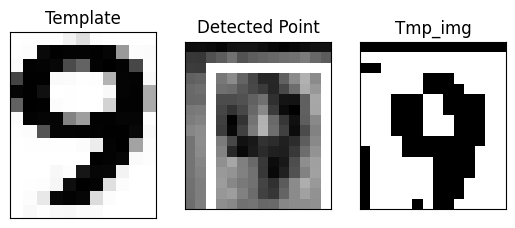

{0: 0.2794856131076813, 1: 0.4991847276687622, 2: 0.17729607224464417, 3: 0.16394411027431488, 4: 0.4724452495574951, 5: 0.17636927962303162, 6: 0.2306140512228012, 7: 0.29093772172927856, 8: 0.28557759523391724, 9: 0.5213965177536011}


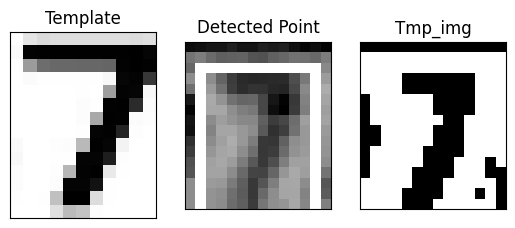

{0: 0.25039392709732056, 1: 0.4150969088077545, 2: 0.48215264081954956, 3: 0.33390331268310547, 4: 0.06387320905923843, 5: 0.16422909498214722, 6: 0.1280023157596588, 7: 0.6977397203445435, 8: 0.15333518385887146, 9: 0.439883291721344}
[{'A': 0.6186972260475159, 'B': 0.1579868495464325, 'C': 0.24438126385211945, 'E': 0.34578874707221985, 'H': 0.22029897570610046, 'K': 0.3625237047672272, 'M': 0.15425515174865723, 'O': 0.2185983508825302, 'P': 0.228746697306633, 'T': 0.2401564121246338, 'X': 0.3757408857345581, 'Y': 0.2805054187774658}, {0: 0.10925289243459702, 1: 0.3702699840068817, 2: 0.09296083450317383, 3: 0.2104281783103943, 4: 0.6856294274330139, 5: 0.05681975930929184, 6: 0.3279757797718048, 7: 0.17128689587116241, 8: 0.1319342702627182, 9: 0.12736797332763672}, {0: 0.13539986312389374, 1: 0.7006624937057495, 2: 0.0897265076637268, 3: 0.25552934408187866, 4: 0.28970298171043396, 5: 0.07542734593153, 6: 0.15193817019462585, 7: 0.20461143553256989, 8: 0.1509658843278885, 9: 0.20263

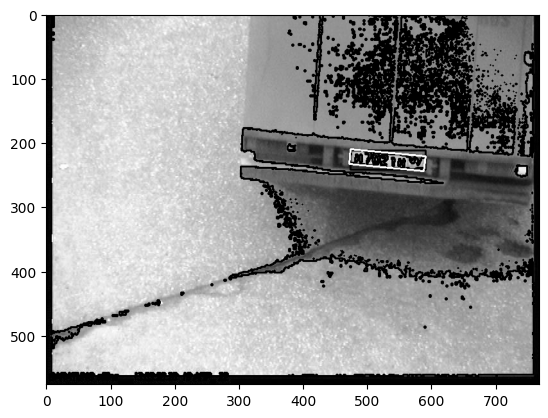

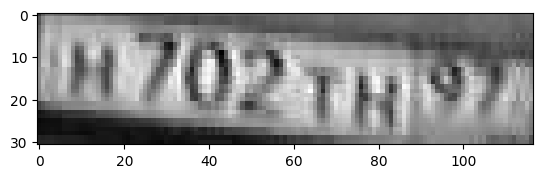

((531.8984985351562, 227.48959350585938), (116.92509460449219, 23.084033966064453), 5.856013774871826)
5.856013774871826


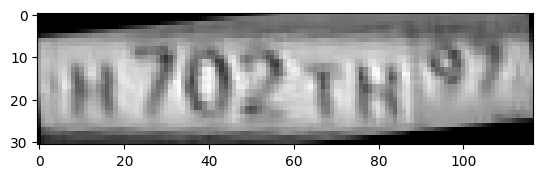

size symbols:  8


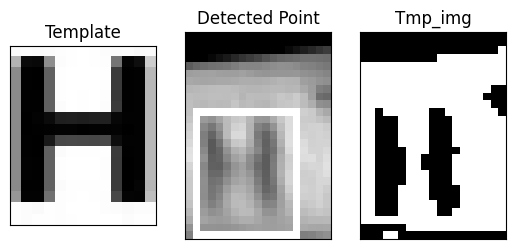

{'A': 0.293449342250824, 'B': 0.543883740901947, 'C': 0.2750544250011444, 'E': 0.45785242319107056, 'H': 0.5898908376693726, 'K': 0.5015065670013428, 'M': 0.1964116096496582, 'O': 0.2575666308403015, 'P': 0.4807555079460144, 'T': 0.4791795313358307, 'X': 0.286767840385437, 'Y': 0.35472115874290466}


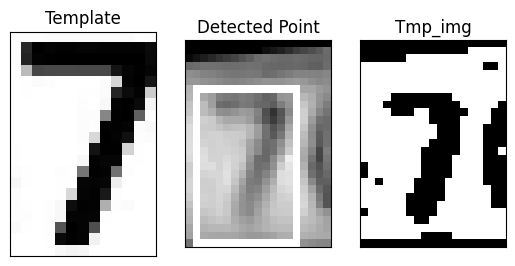

{0: 0.3172275424003601, 1: 0.46709170937538147, 2: 0.44467875361442566, 3: 0.3376416563987732, 4: 0.18682487308979034, 5: 0.23181021213531494, 6: 0.26393425464630127, 7: 0.7341918349266052, 8: 0.26844459772109985, 9: 0.5761138796806335}


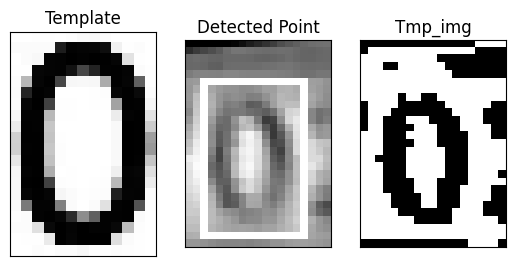

{0: 0.6079035997390747, 1: 0.43498310446739197, 2: 0.19754564762115479, 3: 0.2760389745235443, 4: 0.33389464020729065, 5: 0.26010793447494507, 6: 0.4373778700828552, 7: 0.2491326779127121, 8: 0.5063624382019043, 9: 0.4078390896320343}


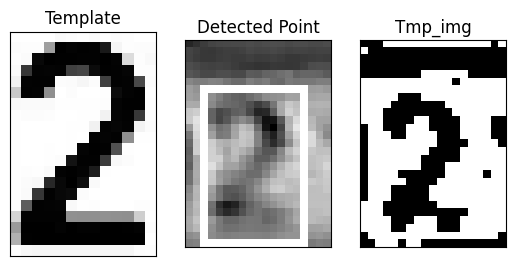

{0: 0.2584173083305359, 1: 0.2668299376964569, 2: 0.6612735986709595, 3: 0.3945092260837555, 4: 0.14602108299732208, 5: 0.5185391902923584, 6: 0.30657705664634705, 7: 0.47990158200263977, 8: 0.3349404036998749, 9: 0.4130246341228485}


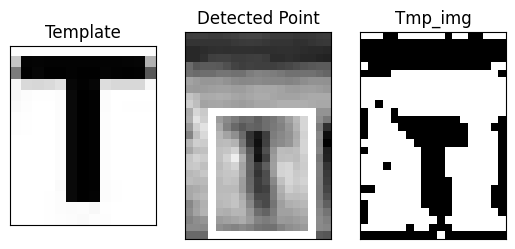

{'A': 0.28389430046081543, 'B': 0.15460066497325897, 'C': 0.35117286443710327, 'E': 0.36050865054130554, 'H': 0.138021320104599, 'K': 0.18320561945438385, 'M': 0.12901560962200165, 'O': 0.21092912554740906, 'P': 0.2007085084915161, 'T': 0.7183322310447693, 'X': 0.37868744134902954, 'Y': 0.4862156808376312}


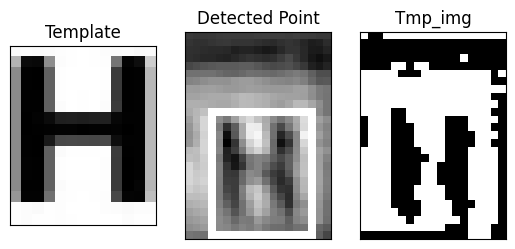

{'A': 0.2770712971687317, 'B': 0.5422039031982422, 'C': 0.23481696844100952, 'E': 0.3706943392753601, 'H': 0.5521805286407471, 'K': 0.5265796184539795, 'M': 0.17120535671710968, 'O': 0.24516840279102325, 'P': 0.4641024172306061, 'T': 0.3479786515235901, 'X': 0.2994011640548706, 'Y': 0.28934159874916077}


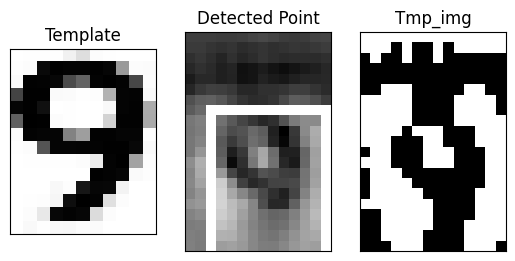

{0: 0.18964506685733795, 1: 0.4381861686706543, 2: 0.3034933805465698, 3: 0.4681597352027893, 4: 0.4703477919101715, 5: 0.27072978019714355, 6: 0.34638485312461853, 7: 0.3181349039077759, 8: 0.28843677043914795, 9: 0.5200583934783936}


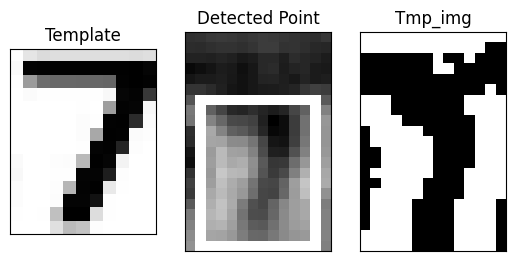

{0: 0.1781516671180725, 1: 0.4406140148639679, 2: 0.39013364911079407, 3: 0.28886136412620544, 4: 0.19586805999279022, 5: 0.3062932789325714, 6: 0.09855390340089798, 7: 0.5861914157867432, 8: 0.1987954080104828, 9: 0.4023243188858032}
[{'A': 0.293449342250824, 'B': 0.543883740901947, 'C': 0.2750544250011444, 'E': 0.45785242319107056, 'H': 0.5898908376693726, 'K': 0.5015065670013428, 'M': 0.1964116096496582, 'O': 0.2575666308403015, 'P': 0.4807555079460144, 'T': 0.4791795313358307, 'X': 0.286767840385437, 'Y': 0.35472115874290466}, {0: 0.3172275424003601, 1: 0.46709170937538147, 2: 0.44467875361442566, 3: 0.3376416563987732, 4: 0.18682487308979034, 5: 0.23181021213531494, 6: 0.26393425464630127, 7: 0.7341918349266052, 8: 0.26844459772109985, 9: 0.5761138796806335}, {0: 0.6079035997390747, 1: 0.43498310446739197, 2: 0.19754564762115479, 3: 0.2760389745235443, 4: 0.33389464020729065, 5: 0.26010793447494507, 6: 0.4373778700828552, 7: 0.2491326779127121, 8: 0.5063624382019043, 9: 0.40783908

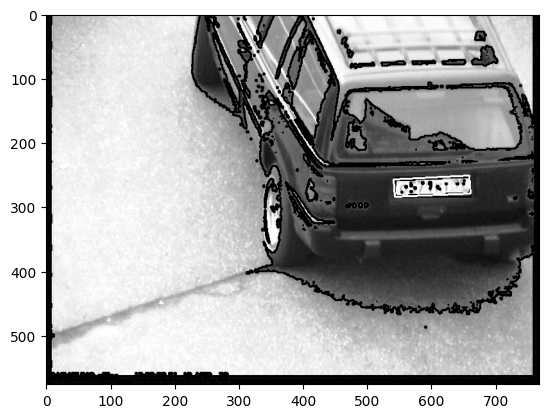

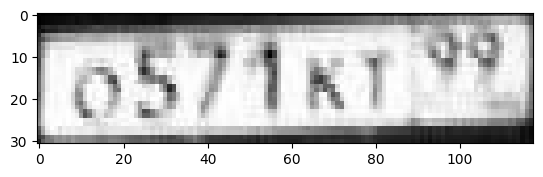

((601.5145263671875, 268.31329345703125), (27.435457229614258, 117.98872375488281), 87.33700561523438)
87.33700561523438


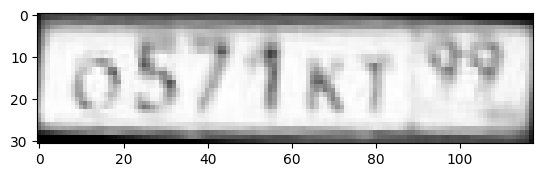

size symbols:  8


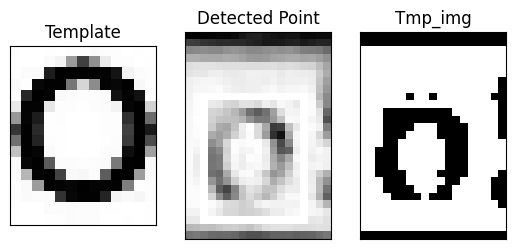

{'A': 0.37531590461730957, 'B': 0.5948696136474609, 'C': 0.5523092746734619, 'E': 0.3713797926902771, 'H': 0.4424876868724823, 'K': 0.2993007004261017, 'M': 0.1852504014968872, 'O': 0.6685421466827393, 'P': 0.520530104637146, 'T': 0.5050144195556641, 'X': 0.24750658869743347, 'Y': 0.2665519118309021}


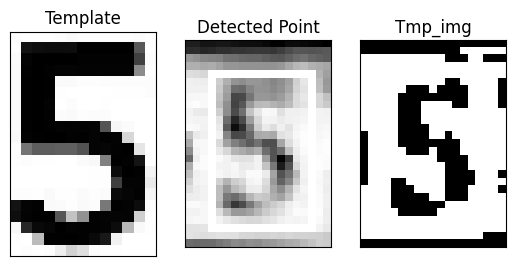

{0: 0.338244765996933, 1: 0.36061084270477295, 2: 0.26201435923576355, 3: 0.5308483839035034, 4: 0.31897595524787903, 5: 0.5975573658943176, 6: 0.5508646368980408, 7: 0.20575128495693207, 8: 0.49993714690208435, 9: 0.47812607884407043}


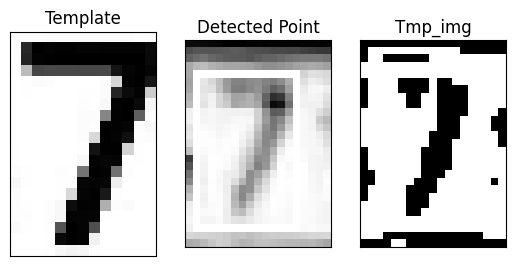

{0: 0.19725435972213745, 1: 0.3300936818122864, 2: 0.4475315511226654, 3: 0.35666167736053467, 4: 0.18773259222507477, 5: 0.14149504899978638, 6: 0.2469709813594818, 7: 0.7495142817497253, 8: 0.18262287974357605, 9: 0.5014692544937134}


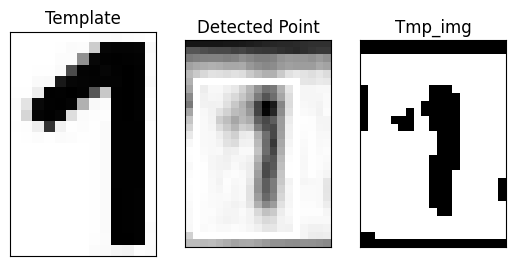

{0: 0.2207409292459488, 1: 0.7145115733146667, 2: 0.24783341586589813, 3: 0.23178498446941376, 4: 0.23664844036102295, 5: 0.13993917405605316, 6: 0.2512435019016266, 7: 0.43677031993865967, 8: 0.24002228677272797, 9: 0.38335293531417847}


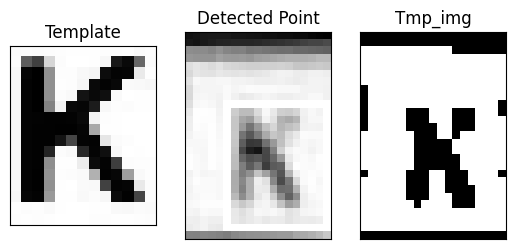

{'A': 0.4986172616481781, 'B': 0.372331440448761, 'C': 0.3321373760700226, 'E': 0.5483363270759583, 'H': 0.20364679396152496, 'K': 0.6748127937316895, 'M': 0.14354979991912842, 'O': 0.13165655732154846, 'P': 0.3916320502758026, 'T': 0.4059276878833771, 'X': 0.6408601403236389, 'Y': 0.47720441222190857}


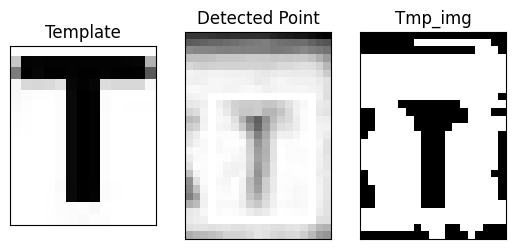

{'A': 0.25480568408966064, 'B': 0.17696063220500946, 'C': 0.25162407755851746, 'E': 0.45400068163871765, 'H': 0.2299925684928894, 'K': 0.22312812507152557, 'M': 0.14456994831562042, 'O': 0.1380491852760315, 'P': 0.3264232873916626, 'T': 0.8190134167671204, 'X': 0.3221109211444855, 'Y': 0.5418762564659119}


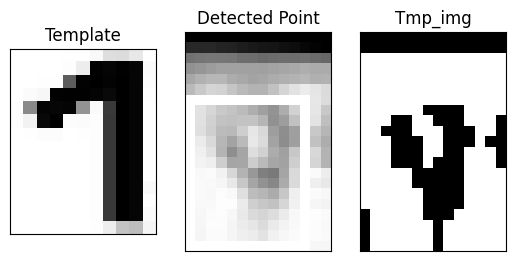

{0: 0.1535715013742447, 1: 0.5269538164138794, 2: 0.272185742855072, 3: 0.24989467859268188, 4: 0.3411061763763428, 5: 0.2504899203777313, 6: 0.3169211149215698, 7: 0.3988820016384125, 8: 0.3114375174045563, 9: 0.5014078617095947}


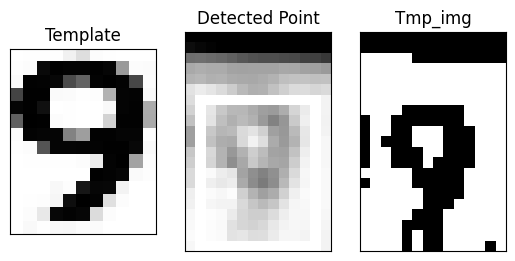

{0: 0.27274090051651, 1: 0.45158851146698, 2: 0.4114972949028015, 3: 0.33808425068855286, 4: 0.410500705242157, 5: 0.2949214279651642, 6: 0.38880977034568787, 7: 0.5467771291732788, 8: 0.3568170964717865, 9: 0.6476471424102783}
[{'A': 0.37531590461730957, 'B': 0.5948696136474609, 'C': 0.5523092746734619, 'E': 0.3713797926902771, 'H': 0.4424876868724823, 'K': 0.2993007004261017, 'M': 0.1852504014968872, 'O': 0.6685421466827393, 'P': 0.520530104637146, 'T': 0.5050144195556641, 'X': 0.24750658869743347, 'Y': 0.2665519118309021}, {0: 0.338244765996933, 1: 0.36061084270477295, 2: 0.26201435923576355, 3: 0.5308483839035034, 4: 0.31897595524787903, 5: 0.5975573658943176, 6: 0.5508646368980408, 7: 0.20575128495693207, 8: 0.49993714690208435, 9: 0.47812607884407043}, {0: 0.19725435972213745, 1: 0.3300936818122864, 2: 0.4475315511226654, 3: 0.35666167736053467, 4: 0.18773259222507477, 5: 0.14149504899978638, 6: 0.2469709813594818, 7: 0.7495142817497253, 8: 0.18262287974357605, 9: 0.5014692544937

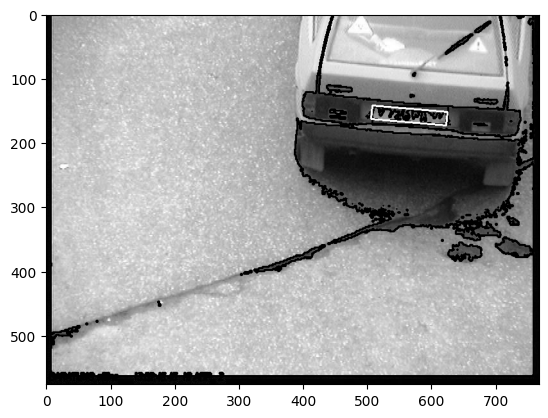

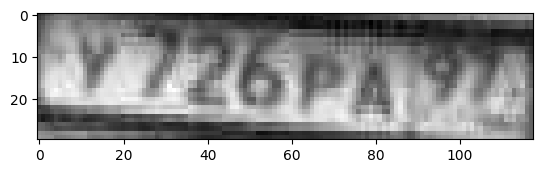

((566.2816772460938, 158.09214782714844), (117.34257507324219, 21.660179138183594), 4.81355094909668)
4.81355094909668


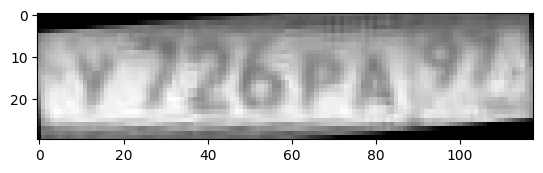

size symbols:  8


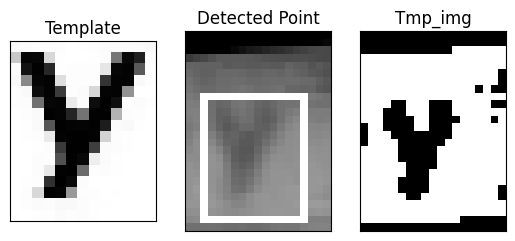

{'A': 0.35616689920425415, 'B': 0.24469898641109467, 'C': 0.2774263322353363, 'E': 0.416848361492157, 'H': 0.19326788187026978, 'K': 0.4298708438873291, 'M': 0.22636672854423523, 'O': 0.11815802752971649, 'P': 0.40049421787261963, 'T': 0.5374718308448792, 'X': 0.47387850284576416, 'Y': 0.7564919590950012}


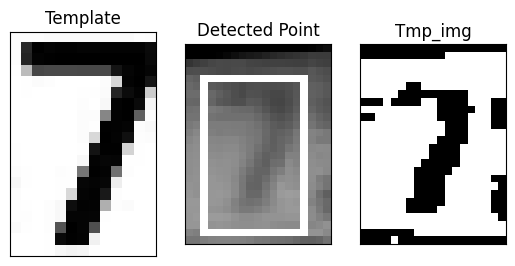

{0: 0.2959277331829071, 1: 0.3883301019668579, 2: 0.5062634944915771, 3: 0.30489209294319153, 4: 0.16453810036182404, 5: 0.17182962596416473, 6: 0.27013155817985535, 7: 0.6950879096984863, 8: 0.20376697182655334, 9: 0.5354627966880798}


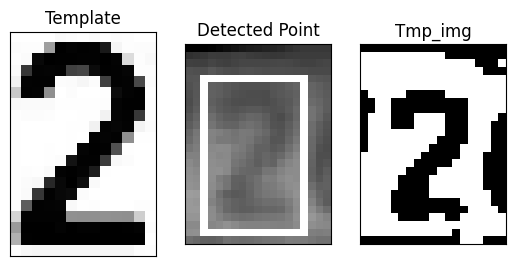

{0: 0.31376391649246216, 1: 0.30952683091163635, 2: 0.6856367588043213, 3: 0.39873024821281433, 4: 0.11589650064706802, 5: 0.27800482511520386, 6: 0.28541818261146545, 7: 0.5038028955459595, 8: 0.42214542627334595, 9: 0.3698645234107971}


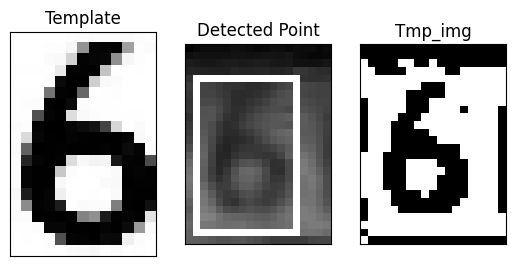

{0: 0.3734065890312195, 1: 0.23751313984394073, 2: 0.13729383051395416, 3: 0.32395225763320923, 4: 0.4487049877643585, 5: 0.4057081937789917, 6: 0.7342533469200134, 7: 0.15382324159145355, 8: 0.5529853105545044, 9: 0.3775442838668823}


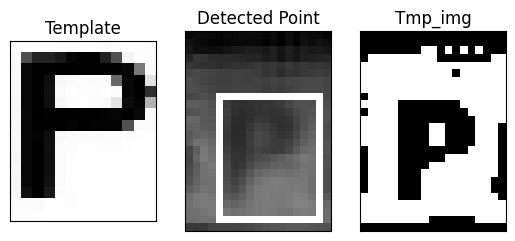

{'A': 0.4868342876434326, 'B': 0.5853939056396484, 'C': 0.35158470273017883, 'E': 0.6207783818244934, 'H': 0.37959837913513184, 'K': 0.43554332852363586, 'M': 0.4036015272140503, 'O': 0.2502707839012146, 'P': 0.7311174273490906, 'T': 0.6041642427444458, 'X': 0.29634809494018555, 'Y': 0.4618586301803589}


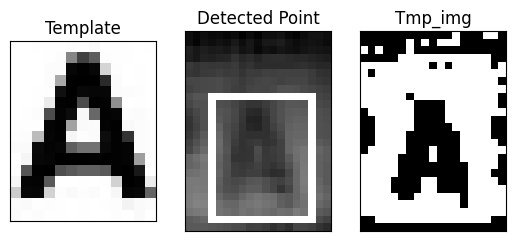

{'A': 0.755774736404419, 'B': 0.2031632959842682, 'C': 0.3133581280708313, 'E': 0.444868266582489, 'H': 0.13532069325447083, 'K': 0.4069465398788452, 'M': 0.27397313714027405, 'O': 0.26380258798599243, 'P': 0.26576530933380127, 'T': 0.3092854619026184, 'X': 0.39330822229385376, 'Y': 0.22695273160934448}


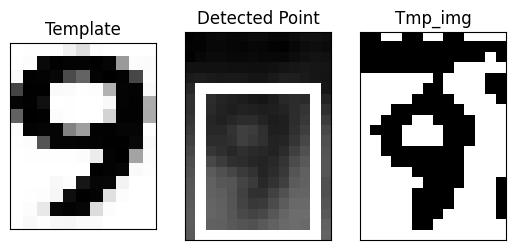

{0: 0.2746489942073822, 1: 0.5499565601348877, 2: 0.3376826345920563, 3: 0.5170338749885559, 4: 0.44680845737457275, 5: 0.41358259320259094, 6: 0.3503668010234833, 7: 0.5397613048553467, 8: 0.35811546444892883, 9: 0.6813657283782959}


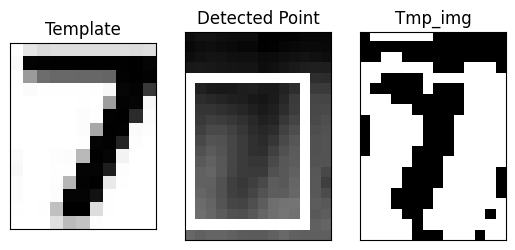

{0: 0.031750574707984924, 1: 0.32006755471229553, 2: 0.3969295024871826, 3: 0.30378106236457825, 4: 0.20458143949508667, 5: 0.3321733772754669, 6: 0.2887548804283142, 7: 0.6162646412849426, 8: 0.15392102301120758, 9: 0.37811318039894104}
[{'A': 0.35616689920425415, 'B': 0.24469898641109467, 'C': 0.2774263322353363, 'E': 0.416848361492157, 'H': 0.19326788187026978, 'K': 0.4298708438873291, 'M': 0.22636672854423523, 'O': 0.11815802752971649, 'P': 0.40049421787261963, 'T': 0.5374718308448792, 'X': 0.47387850284576416, 'Y': 0.7564919590950012}, {0: 0.2959277331829071, 1: 0.3883301019668579, 2: 0.5062634944915771, 3: 0.30489209294319153, 4: 0.16453810036182404, 5: 0.17182962596416473, 6: 0.27013155817985535, 7: 0.6950879096984863, 8: 0.20376697182655334, 9: 0.5354627966880798}, {0: 0.31376391649246216, 1: 0.30952683091163635, 2: 0.6856367588043213, 3: 0.39873024821281433, 4: 0.11589650064706802, 5: 0.27800482511520386, 6: 0.28541818261146545, 7: 0.5038028955459595, 8: 0.42214542627334595, 9

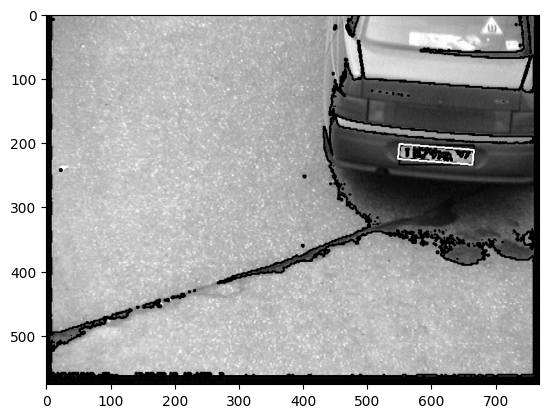

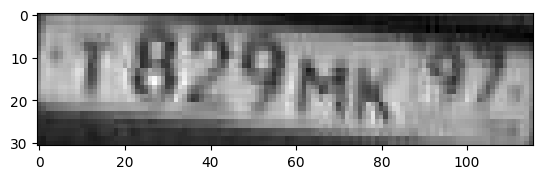

((607.695556640625, 218.55563354492188), (116.06918334960938, 23.644458770751953), 4.573921203613281)
4.573921203613281


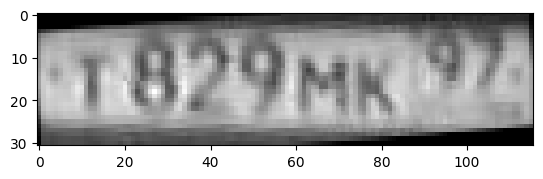

size symbols:  8


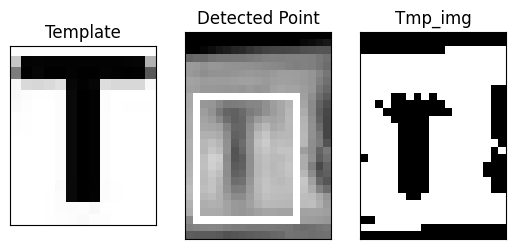

{'A': 0.2824572026729584, 'B': 0.36908507347106934, 'C': 0.366756409406662, 'E': 0.5752031803131104, 'H': 0.3810695707798004, 'K': 0.333597868680954, 'M': 0.4738507568836212, 'O': 0.2115182876586914, 'P': 0.5235212445259094, 'T': 0.7497230172157288, 'X': 0.33807432651519775, 'Y': 0.49034374952316284}


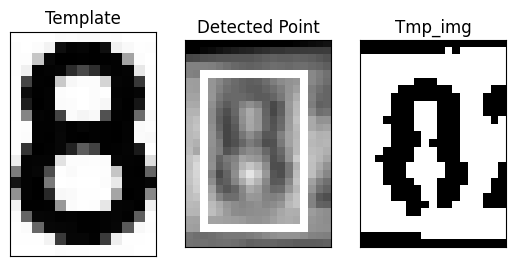

{0: 0.5646556615829468, 1: 0.5071012377738953, 2: 0.2313031107187271, 3: 0.2966635525226593, 4: 0.41912180185317993, 5: 0.4047260284423828, 6: 0.5476454496383667, 7: 0.19125206768512726, 8: 0.6693462133407593, 9: 0.3949888348579407}


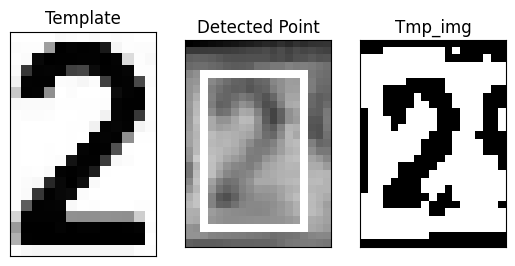

{0: 0.3189699649810791, 1: 0.33566686511039734, 2: 0.6927474737167358, 3: 0.34304967522621155, 4: 0.1150096133351326, 5: 0.29730716347694397, 6: 0.14075352251529694, 7: 0.4555354118347168, 8: 0.37143465876579285, 9: 0.3208971321582794}


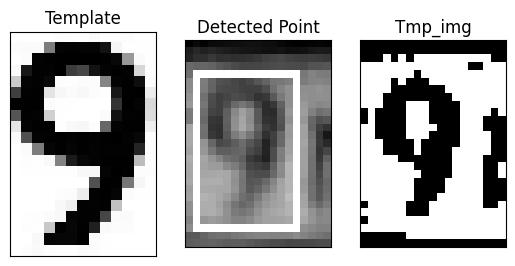

{0: 0.33336788415908813, 1: 0.46440714597702026, 2: 0.28501617908477783, 3: 0.1484060436487198, 4: 0.41115787625312805, 5: 0.32107430696487427, 6: 0.26965075731277466, 7: 0.5100271701812744, 8: 0.4000367224216461, 9: 0.7445084452629089}


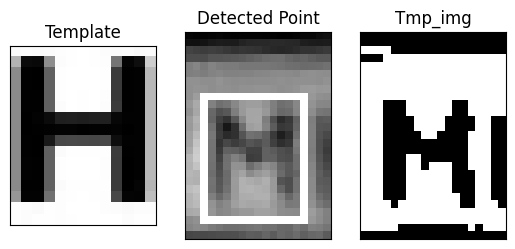

{'A': 0.32566601037979126, 'B': 0.45793795585632324, 'C': 0.24934148788452148, 'E': 0.36181625723838806, 'H': 0.7553184628486633, 'K': 0.4574231505393982, 'M': 0.6103925704956055, 'O': 0.27024585008621216, 'P': 0.5603306293487549, 'T': 0.2947016954421997, 'X': 0.2510486841201782, 'Y': 0.2732865810394287}


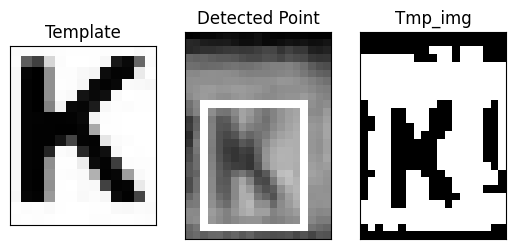

{'A': 0.39660027623176575, 'B': 0.3362186551094055, 'C': 0.4042914807796478, 'E': 0.5207859873771667, 'H': 0.33924299478530884, 'K': 0.6552576422691345, 'M': 0.296884149312973, 'O': 0.3909514844417572, 'P': 0.3849349319934845, 'T': 0.28956088423728943, 'X': 0.6192198395729065, 'Y': 0.5232311487197876}


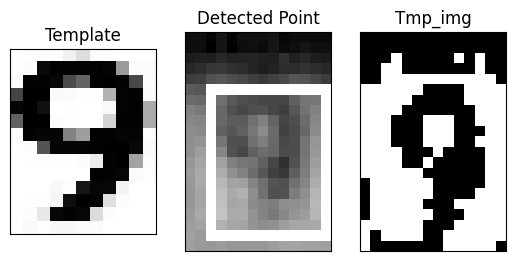

{0: 0.3140481114387512, 1: 0.5694822669029236, 2: 0.2731865346431732, 3: 0.3595280051231384, 4: 0.43019989132881165, 5: 0.3280583620071411, 6: 0.3635846674442291, 7: 0.4547160565853119, 8: 0.37286239862442017, 9: 0.5717285871505737}


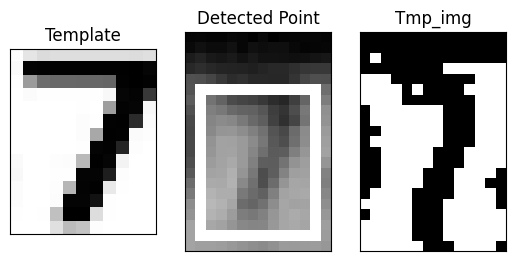

{0: 0.26347967982292175, 1: 0.4190692901611328, 2: 0.4080917239189148, 3: 0.3063567578792572, 4: 0.13021546602249146, 5: 0.3264785408973694, 6: 0.24063581228256226, 7: 0.6559406518936157, 8: 0.11081764847040176, 9: 0.37128686904907227}
[{'A': 0.2824572026729584, 'B': 0.36908507347106934, 'C': 0.366756409406662, 'E': 0.5752031803131104, 'H': 0.3810695707798004, 'K': 0.333597868680954, 'M': 0.4738507568836212, 'O': 0.2115182876586914, 'P': 0.5235212445259094, 'T': 0.7497230172157288, 'X': 0.33807432651519775, 'Y': 0.49034374952316284}, {0: 0.5646556615829468, 1: 0.5071012377738953, 2: 0.2313031107187271, 3: 0.2966635525226593, 4: 0.41912180185317993, 5: 0.4047260284423828, 6: 0.5476454496383667, 7: 0.19125206768512726, 8: 0.6693462133407593, 9: 0.3949888348579407}, {0: 0.3189699649810791, 1: 0.33566686511039734, 2: 0.6927474737167358, 3: 0.34304967522621155, 4: 0.1150096133351326, 5: 0.29730716347694397, 6: 0.14075352251529694, 7: 0.4555354118347168, 8: 0.37143465876579285, 9: 0.32089713

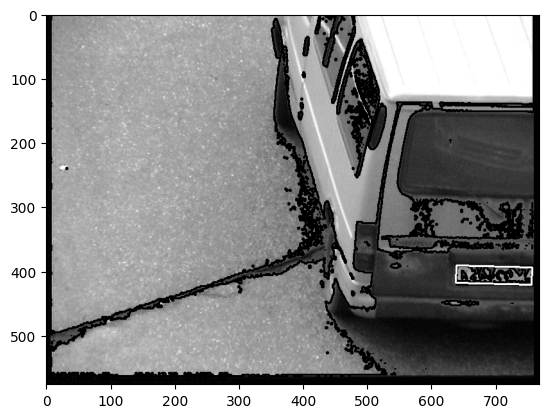

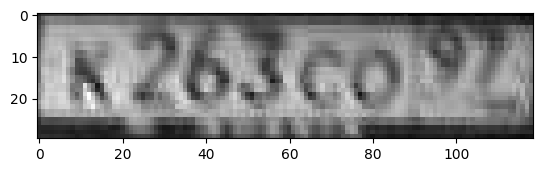

((697.99658203125, 406.6092834472656), (118.22354125976562, 26.955591201782227), 1.7899105548858643)
1.7899105548858643


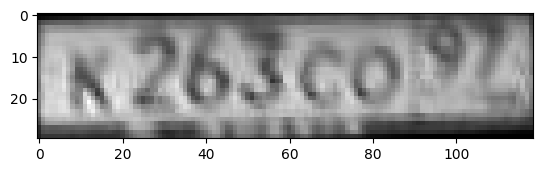

size symbols:  8


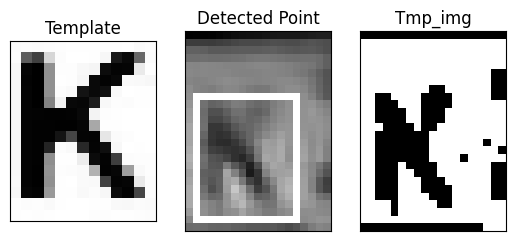

{'A': 0.42857423424720764, 'B': 0.300682932138443, 'C': 0.39620763063430786, 'E': 0.5041903853416443, 'H': 0.19519956409931183, 'K': 0.6911829710006714, 'M': 0.17459872364997864, 'O': 0.3364258408546448, 'P': 0.37362778186798096, 'T': 0.21964144706726074, 'X': 0.6049264669418335, 'Y': 0.5001498460769653}


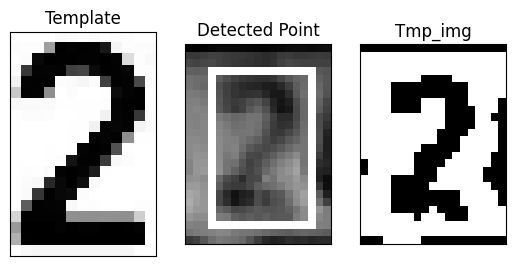

{0: 0.28784987330436707, 1: 0.33777323365211487, 2: 0.7899475693702698, 3: 0.41705214977264404, 4: 0.16090725362300873, 5: 0.23023103177547455, 6: 0.2667570114135742, 7: 0.5601492524147034, 8: 0.3173339068889618, 9: 0.3531714677810669}


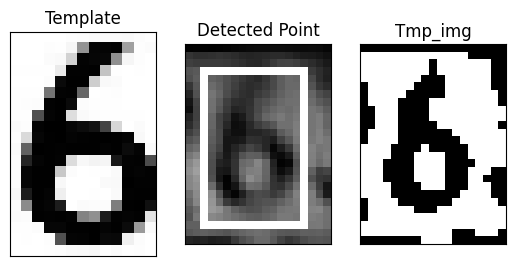

{0: 0.342594712972641, 1: 0.2060375213623047, 2: 0.15001355111598969, 3: 0.374853253364563, 4: 0.41661715507507324, 5: 0.43369412422180176, 6: 0.745464026927948, 7: 0.05286388844251633, 8: 0.5590825080871582, 9: 0.3283689022064209}


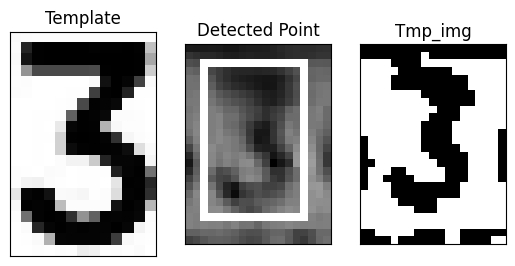

{0: 0.3535294830799103, 1: 0.3395698666572571, 2: 0.43380144238471985, 3: 0.6436512470245361, 4: 0.2653690278530121, 5: 0.39032843708992004, 6: 0.23833857476711273, 7: 0.47580090165138245, 8: 0.431248277425766, 9: 0.3219476640224457}


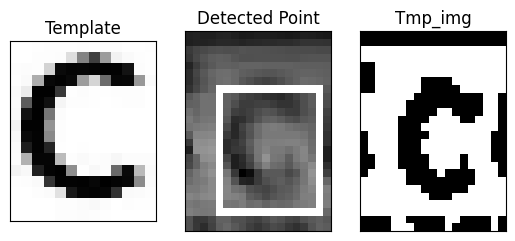

{'A': 0.3955085873603821, 'B': 0.4566713273525238, 'C': 0.7089497447013855, 'E': 0.5249810218811035, 'H': 0.2615049481391907, 'K': 0.2502089738845825, 'M': 0.2674948275089264, 'O': 0.4959137439727783, 'P': 0.34306827187538147, 'T': 0.4440302550792694, 'X': 0.2544013559818268, 'Y': 0.33712875843048096}


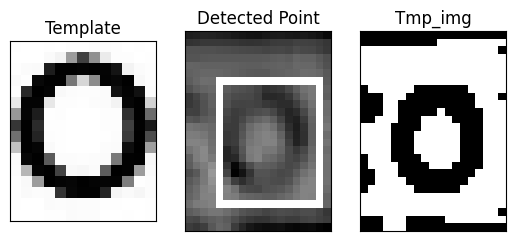

{'A': 0.34722086787223816, 'B': 0.585695207118988, 'C': 0.5910991430282593, 'E': 0.3818954825401306, 'H': 0.4065060317516327, 'K': 0.3151823878288269, 'M': 0.16811902821063995, 'O': 0.6819548606872559, 'P': 0.35882145166397095, 'T': 0.44908249378204346, 'X': 0.24329157173633575, 'Y': 0.21798494458198547}


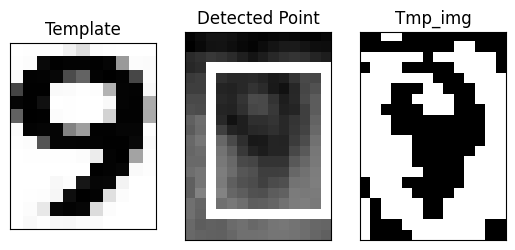

{0: 0.29125696420669556, 1: 0.3874973952770233, 2: 0.2974244952201843, 3: 0.234964519739151, 4: 0.38958704471588135, 5: 0.26933008432388306, 6: 0.27757737040519714, 7: 0.4684458076953888, 8: 0.32816562056541443, 9: 0.5492812991142273}


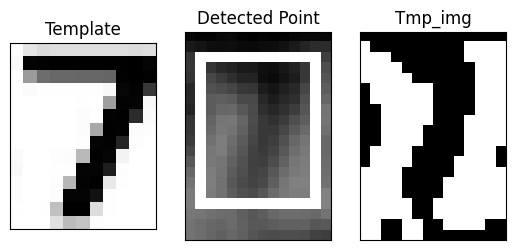

{0: 0.22044269740581512, 1: 0.37851598858833313, 2: 0.3981088697910309, 3: 0.2702192962169647, 4: 0.23317672312259674, 5: 0.05005323141813278, 6: 0.2995285093784332, 7: 0.5690888166427612, 8: 0.08129800111055374, 9: 0.34273484349250793}
[{'A': 0.42857423424720764, 'B': 0.300682932138443, 'C': 0.39620763063430786, 'E': 0.5041903853416443, 'H': 0.19519956409931183, 'K': 0.6911829710006714, 'M': 0.17459872364997864, 'O': 0.3364258408546448, 'P': 0.37362778186798096, 'T': 0.21964144706726074, 'X': 0.6049264669418335, 'Y': 0.5001498460769653}, {0: 0.28784987330436707, 1: 0.33777323365211487, 2: 0.7899475693702698, 3: 0.41705214977264404, 4: 0.16090725362300873, 5: 0.23023103177547455, 6: 0.2667570114135742, 7: 0.5601492524147034, 8: 0.3173339068889618, 9: 0.3531714677810669}, {0: 0.342594712972641, 1: 0.2060375213623047, 2: 0.15001355111598969, 3: 0.374853253364563, 4: 0.41661715507507324, 5: 0.43369412422180176, 6: 0.745464026927948, 7: 0.05286388844251633, 8: 0.5590825080871582, 9: 0.3283

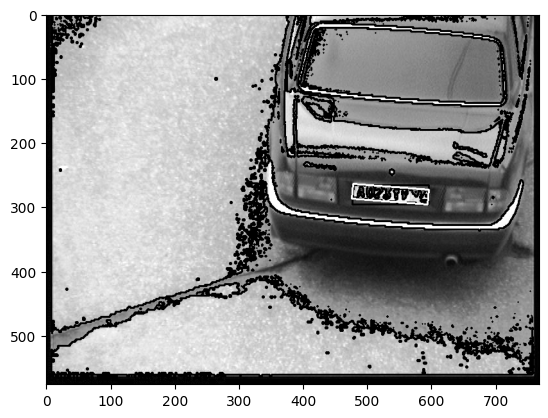

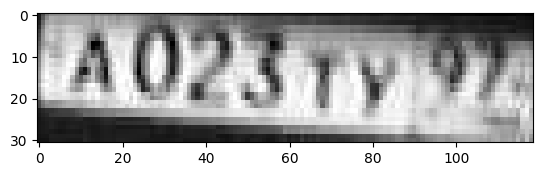

((536.452880859375, 280.61175537109375), (118.80288696289062, 23.39243507385254), 4.398705005645752)
4.398705005645752


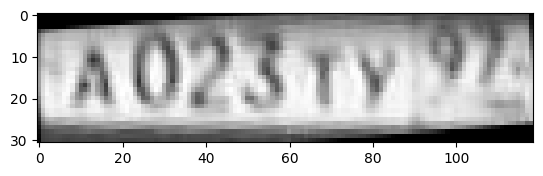

size symbols:  8


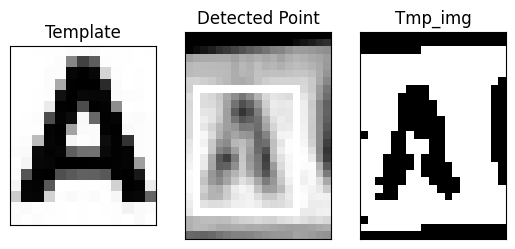

{'A': 0.7225297689437866, 'B': 0.3302868604660034, 'C': 0.27994322776794434, 'E': 0.4004613757133484, 'H': 0.22404882311820984, 'K': 0.3957746922969818, 'M': 0.22849445044994354, 'O': 0.1957632154226303, 'P': 0.3276333808898926, 'T': 0.38868504762649536, 'X': 0.3347543478012085, 'Y': 0.2547707259654999}


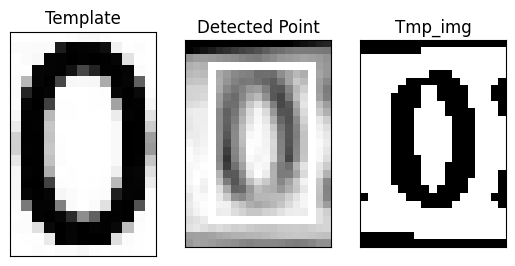

{0: 0.7724040150642395, 1: 0.4193659722805023, 2: 0.28679126501083374, 3: 0.23692966997623444, 4: 0.27546167373657227, 5: 0.3774653375148773, 6: 0.4566827714443207, 7: 0.29817184805870056, 8: 0.6336787343025208, 9: 0.46067291498184204}


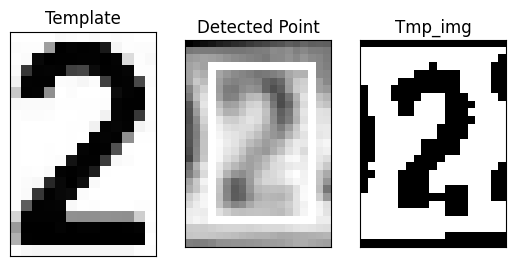

{0: 0.3035163879394531, 1: 0.4049913287162781, 2: 0.7592251300811768, 3: 0.39925041794776917, 4: 0.2859116196632385, 5: 0.26365071535110474, 6: 0.2061290442943573, 7: 0.4905347526073456, 8: 0.34772735834121704, 9: 0.35414600372314453}


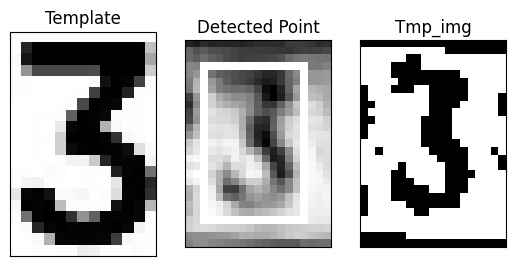

{0: 0.29653170704841614, 1: 0.3394223153591156, 2: 0.3974023163318634, 3: 0.7430905699729919, 4: 0.2889549434185028, 5: 0.4261074960231781, 6: 0.2585861086845398, 7: 0.39373910427093506, 8: 0.38490942120552063, 9: 0.22813695669174194}


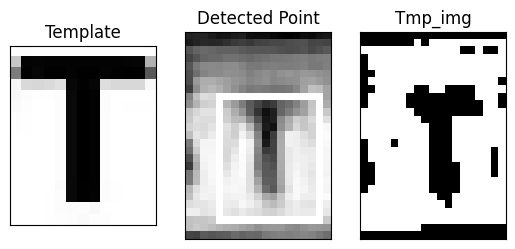

{'A': 0.27860236167907715, 'B': 0.14950357377529144, 'C': 0.2526750862598419, 'E': 0.3724949359893799, 'H': 0.3141794502735138, 'K': 0.14632056653499603, 'M': 0.3188892900943756, 'O': 0.1790561079978943, 'P': 0.14879503846168518, 'T': 0.7648361325263977, 'X': 0.30373817682266235, 'Y': 0.47813424468040466}


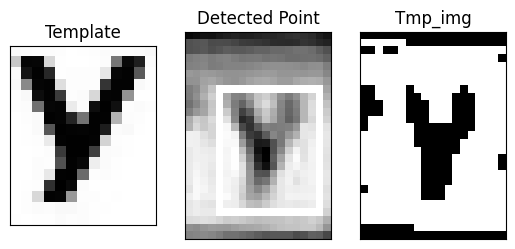

{'A': 0.28704530000686646, 'B': 0.23953722417354584, 'C': 0.28948119282722473, 'E': 0.40760406851768494, 'H': 0.13528645038604736, 'K': 0.37239891290664673, 'M': 0.15556186437606812, 'O': 0.15384118258953094, 'P': 0.31781595945358276, 'T': 0.5747060179710388, 'X': 0.4700736701488495, 'Y': 0.7196894288063049}


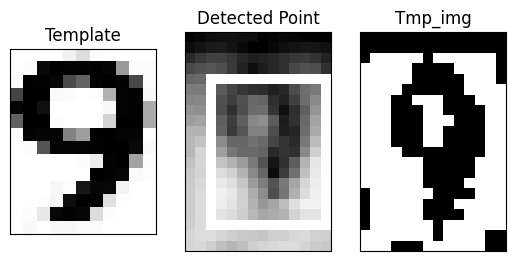

{0: 0.3438122868537903, 1: 0.5048368573188782, 2: 0.28827640414237976, 3: 0.23368357121944427, 4: 0.41787347197532654, 5: 0.23785148561000824, 6: 0.3938654661178589, 7: 0.5024912357330322, 8: 0.31522127985954285, 9: 0.584796667098999}


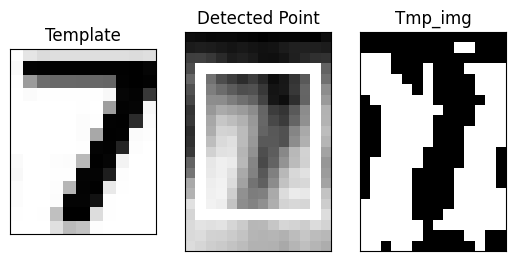

{0: 0.2547324001789093, 1: 0.40191447734832764, 2: 0.3861852288246155, 3: 0.26967403292655945, 4: 0.20159593224525452, 5: 0.13806192576885223, 6: 0.2289866805076599, 7: 0.5784506797790527, 8: 0.0714806318283081, 9: 0.3294421136379242}
[{'A': 0.7225297689437866, 'B': 0.3302868604660034, 'C': 0.27994322776794434, 'E': 0.4004613757133484, 'H': 0.22404882311820984, 'K': 0.3957746922969818, 'M': 0.22849445044994354, 'O': 0.1957632154226303, 'P': 0.3276333808898926, 'T': 0.38868504762649536, 'X': 0.3347543478012085, 'Y': 0.2547707259654999}, {0: 0.7724040150642395, 1: 0.4193659722805023, 2: 0.28679126501083374, 3: 0.23692966997623444, 4: 0.27546167373657227, 5: 0.3774653375148773, 6: 0.4566827714443207, 7: 0.29817184805870056, 8: 0.6336787343025208, 9: 0.46067291498184204}, {0: 0.3035163879394531, 1: 0.4049913287162781, 2: 0.7592251300811768, 3: 0.39925041794776917, 4: 0.2859116196632385, 5: 0.26365071535110474, 6: 0.2061290442943573, 7: 0.4905347526073456, 8: 0.34772735834121704, 9: 0.35414

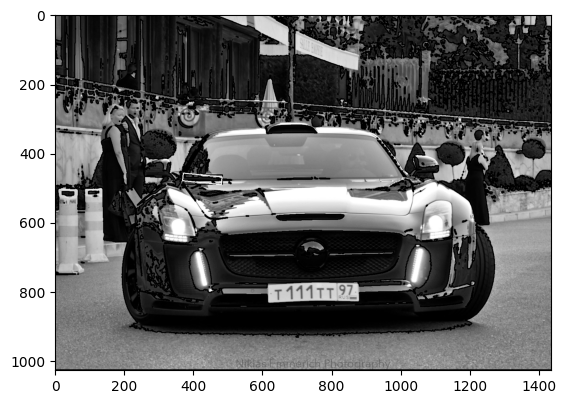

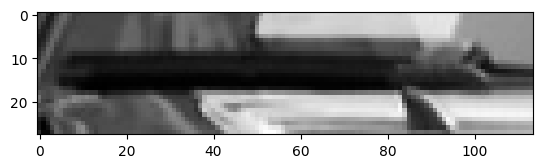

((425.7034912109375, 473.935546875), (112.6510009765625, 22.244264602661133), 5.630682468414307)
5.630682468414307


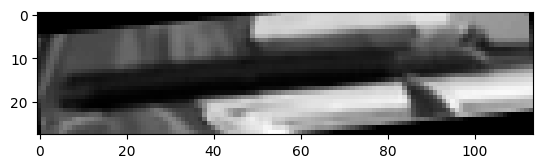

size symbols:  8


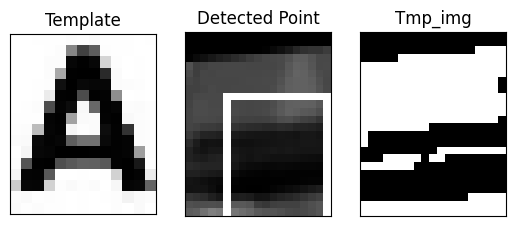

{'A': 0.4051775336265564, 'B': 0.27062860131263733, 'C': 0.11665613204240799, 'E': 0.1753140091896057, 'H': 0.3257356286048889, 'K': 0.17920802533626556, 'M': 0.27139851450920105, 'O': 0.23513734340667725, 'P': 0.11763588339090347, 'T': 0.14636282622814178, 'X': 0.2143595963716507, 'Y': 0.10324884206056595}


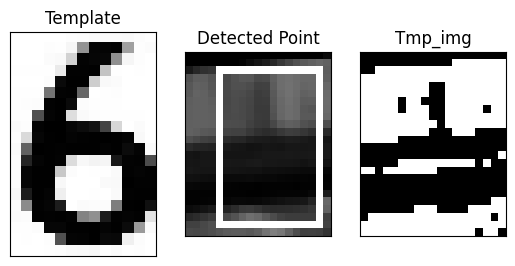

{0: 0.17911772429943085, 1: 0.0658714696764946, 2: 0.18052130937576294, 3: 0.1953638195991516, 4: 0.30229705572128296, 5: 0.22575455904006958, 6: 0.4322061240673065, 7: 0.011718973517417908, 8: 0.3275905251502991, 9: 0.14808021485805511}


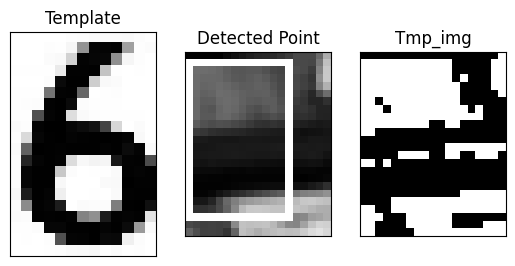

{0: 0.15085358917713165, 1: 0.14685451984405518, 2: 0.17291320860385895, 3: 0.16645832359790802, 4: 0.28304120898246765, 5: 0.07809137552976608, 6: 0.2954374849796295, 7: 0.11335383355617523, 8: 0.24412478506565094, 9: 0.11944708973169327}


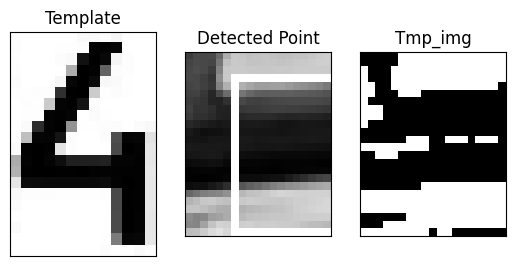

{0: 0.08652088046073914, 1: 0.247890442609787, 2: 0.08049087971448898, 3: 0.1074884906411171, 4: 0.3066736161708832, 5: 0.13891083002090454, 6: 0.19196367263793945, 7: 0.21773724257946014, 8: 0.26493749022483826, 9: 0.2702544331550598}


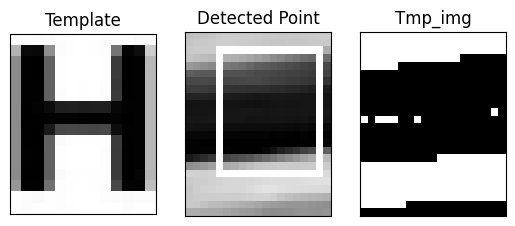

{'A': 0.3640953004360199, 'B': 0.39635714888572693, 'C': 0.32167118787765503, 'E': 0.3024462163448334, 'H': 0.4248476028442383, 'K': 0.3412904441356659, 'M': 0.40099021792411804, 'O': 0.4062996506690979, 'P': 0.38082993030548096, 'T': 0.28332406282424927, 'X': 0.3103511333465576, 'Y': 0.3355531692504883}


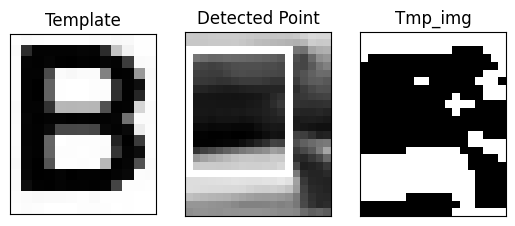

{'A': 0.43011143803596497, 'B': 0.4733099639415741, 'C': 0.31309646368026733, 'E': 0.31774547696113586, 'H': 0.46197763085365295, 'K': 0.4039335250854492, 'M': 0.4016402065753937, 'O': 0.35529637336730957, 'P': 0.44421157240867615, 'T': 0.2832621932029724, 'X': 0.3552834689617157, 'Y': 0.35680267214775085}


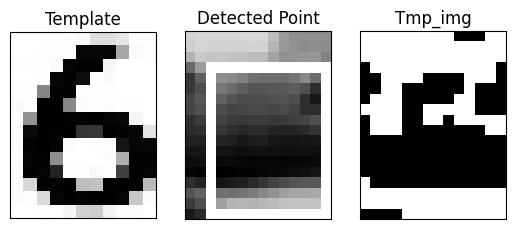

{0: 0.3058129847049713, 1: 0.16696184873580933, 2: 0.113630011677742, 3: 0.28476834297180176, 4: 0.44560113549232483, 5: 0.24195745587348938, 6: 0.46416497230529785, 7: 0.17653492093086243, 8: 0.4195336401462555, 9: 0.3049755096435547}


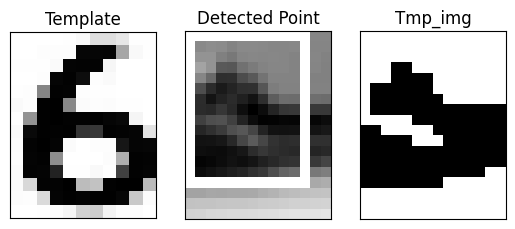

{0: 0.29064512252807617, 1: 0.13231801986694336, 2: 0.06624001264572144, 3: 0.225275456905365, 4: 0.2756415903568268, 5: 0.2953864634037018, 6: 0.41935044527053833, 7: 0.13452011346817017, 8: 0.3376924395561218, 9: 0.2647814452648163}
[{'A': 0.4051775336265564, 'B': 0.27062860131263733, 'C': 0.11665613204240799, 'E': 0.1753140091896057, 'H': 0.3257356286048889, 'K': 0.17920802533626556, 'M': 0.27139851450920105, 'O': 0.23513734340667725, 'P': 0.11763588339090347, 'T': 0.14636282622814178, 'X': 0.2143595963716507, 'Y': 0.10324884206056595}, {0: 0.17911772429943085, 1: 0.0658714696764946, 2: 0.18052130937576294, 3: 0.1953638195991516, 4: 0.30229705572128296, 5: 0.22575455904006958, 6: 0.4322061240673065, 7: 0.011718973517417908, 8: 0.3275905251502991, 9: 0.14808021485805511}, {0: 0.15085358917713165, 1: 0.14685451984405518, 2: 0.17291320860385895, 3: 0.16645832359790802, 4: 0.28304120898246765, 5: 0.07809137552976608, 6: 0.2954374849796295, 7: 0.11335383355617523, 8: 0.24412478506565094,

In [8]:
for i in range(1, 10):
    for thr in range(60, 200, 10):
        print('thr: ', thr)
        img = read_img(f'img{i}.jpg', cv.IMREAD_GRAYSCALE)
        start_img = read_img(f'img{i}.jpg', cv.IMREAD_GRAYSCALE)
        _, img_threshold = cv.threshold(img,thr,255,cv.THRESH_BINARY)

        contours, _ = cv.findContours(img_threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        cv.drawContours(img,contours,-1,(0,100,255),2)
        if find_goal_img(contours, img, start_img) != None:
            break